# Occupation-skills matrix differentiating between essential and optional skills
Felix Zaussinger | 30.07.2021

In [50]:
import os
import sys
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("ticks")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define directory structure

In [51]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_interim = os.path.join(project_dir, "data", "interim")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "reports", "figures")

ESCO data set components

In [52]:
occ = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "occupations_en.csv"))
skill_groups = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "skillGroups_en.csv"))
skills = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "skills_en.csv"))
occ_skills_mapping = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "occupationSkillRelations.csv"))

### Build occupation - skills matrix

**Encoding**
- 0: skill not required
- 1: skill required, essential
- 2: skill required, optional

In [53]:
errors = 0
skill_vectors = []

for i in tqdm(range(len(occ))):
    occ_uri = occ.iloc[i, :][1]

    # lookup corresponding skills
    skill_list = occ_skills_mapping[occ_skills_mapping["occupationUri"] == occ_uri]

    # create vector
    skill_vector = []
    for j, skill in enumerate(skills.conceptUri.values):

        if skill in skill_list.skillUri.values:
            relation_type = skill_list.loc[skill_list.skillUri == skill, "relationType"].values[0]

            # skill needed for occupation and essential
            if relation_type == "essential":
                skill_vector.append(1)
            # skill needed for occupation and optional
            elif relation_type == "optional":
                skill_vector.append(2)
        else:
            # skill not needed for occupation
            skill_vector.append(0)

    indices = [i for i, j in enumerate(skill_vector) if j == 1]

    # sanity check
    if len(skill_list.skillUri) != np.sum(np.invert(np.array(skill_vector) == 0)):
        errors += 1

    # append
    skill_vectors.append(skill_vector)

# info
print("n_errors: ", errors)

# create df
occ_skills_matrix = pd.DataFrame(
    index=occ.conceptUri,
    columns=skills.conceptUri,
    data=np.array(skill_vectors)
)

100%|██████████| 2942/2942 [12:48<00:00,  3.83it/s]


n_errors:  3


In [59]:
# save
occ_skills_matrix.to_pickle(
    os.path.join(project_dir, "data", "processed", "adjacency_matrix_essential_optional.pkl")
)

<AxesSubplot:>

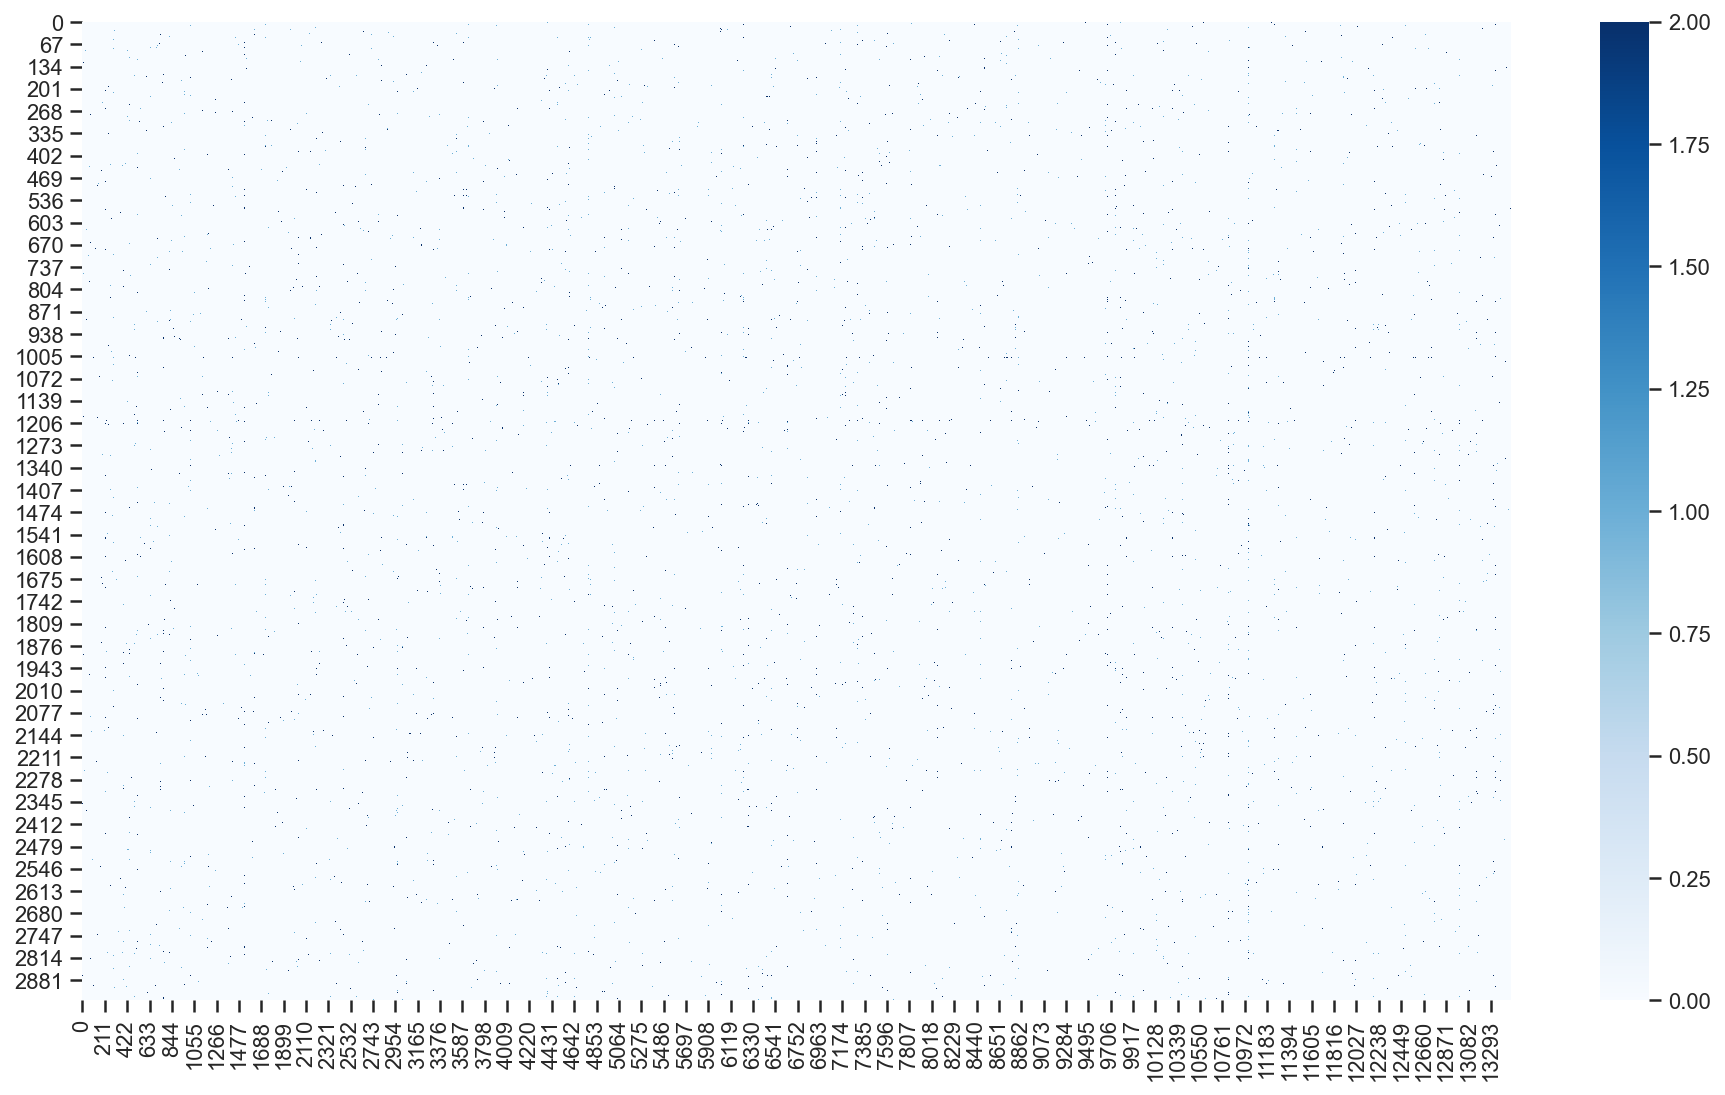

In [58]:
sns.heatmap(occ_skills_matrix.values, cmap="Blues")